In [1]:
import numpy as np
import cytnx as ct
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def get_delta(beta,h):
    delta_t = ct.zeros((2,2,2,2))
    delta_t[0,0,0,0] = np.exp(beta*h)
    delta_t[1,1,1,1] = np.exp(-beta*h)
    delta_ut = ct.UniTensor(delta_t, rowrank=2)
    return delta_ut

In [3]:
def merge_y(T1,T2,combine=True):
    net = ct.Network('./network/merge_y.net')
    net.PutUniTensors(['T1','T2'],[T1,T2])
    L2 = net.Launch()
    if combine:
        L2.combineBonds([1,2])
        L2.combineBonds([3,4])
    return L2

In [4]:
def merge_x(T1,T2,combine=True):
    net = ct.Network('./network/merge_x.net')
    net.PutUniTensors(['T1','T2'],[T1,T2])
    L2 = net.Launch()
    if combine:
        L2.combineBonds([0,1])
        L2.combineBonds([4,5])
    return L2

In [5]:
def get_T(J,beta,delta_ut):
    W=(np.exp(np.array([[J*beta, -J*beta],[-J*beta,J*beta]])))
    W_t = ct.from_numpy(W)
    S_t,U_t,Vd_t = ct.linalg.Svd(W_t)
    M_t = (U_t @ ct.linalg.Diag(S_t.Pow(0.5)))
    M_ut = ct.UniTensor(M_t,rowrank=1)
    net = ct.Network('./network/transfer.net')
    net.PutUniTensors(['delta','M1','M2','M3','M4'],
                  [delta_ut,M_ut,M_ut,M_ut,M_ut])
    return net.Launch()

In [6]:
def merge_22_y(Tu,Td):
    net = ct.Network('./network/merge_22_y.net')
    net.PutUniTensors(['Tu','Tu.d','Td','Td.d'],[Tu,Tu,Td,Td])
    return net.Launch()

In [7]:
def merge_22_x(Tr,Tl):
    net = ct.Network('./network/merge_22_x.net')
    net.PutUniTensors(['Tr','Tr.d','Tl','Tl.d'],[Tr,Tr,Tl,Tl])
    return net.Launch()

In [8]:
def approximate_y(Tu,Td,dim):
    T = merge_22_y(Tu,Td)
    T = T / np.mean(T.get_block().numpy())
    _, U, _ = ct.linalg.Svd_truncate(T,dim)
    TuTd = merge_y(Tu,Td,combine=False)
    net = ct.Network('./network/transform_y.net')
    net.PutUniTensors(['TuTd','U','U.d'],[TuTd,U,U])
    T = net.Launch()
    return  T / np.mean(T.get_block().numpy())

In [9]:
def approximate_x(Tr,Tl,dim):
    T = merge_22_x(Tr,Tl)
    T = T / np.mean(T.get_block().numpy())
    _, U, _ = ct.linalg.Svd_truncate(T,dim)
    TlTr = merge_x(Tl,Tr,combine=False)
    net = ct.Network('./network/transform_x.net')
    net.PutUniTensors(['TlTr','U','U.d'],[TlTr,U,U])
    T = net.Launch()
    return  T / np.mean(T.get_block().numpy())

# 2$\times$2 Merge

In [19]:
J=1
h=0
beta = 1/np.geomspace(2.26,2.36,50)

In [30]:
T = {}
TM = {}
dcut = 16
xi = {}
L_max = 16
i=1
while i<=L_max:
    xi[(i,i)]=[]
    i*=2

for b in beta:
    i=1
    delta_ut = get_delta(b,h)
    T[(1,1)] = get_T(J,b,delta_ut)
    while i<L_max:
        dim = np.min([dcut,(i*2)**2])
        T_=approximate_y(T[(i,i)],T[(i,i)],dim)
        T[(i*2,i*2)]=approximate_x(T_,T_,dim)
        i*=2
        TM[(i,i)] = T[(i,i)].get_block().numpy()
        TM[(i,i)] = np.trace(TM[(i,i)],axis1=0,axis2=3)
        v_,_ = np.linalg.eigh(TM[(i,i)])
        v_ = v_[::-1]
        E = -np.log(v_[:2])
        xi[(i,i)].append(1/(E[1]-E[0]))
del T, TM, E

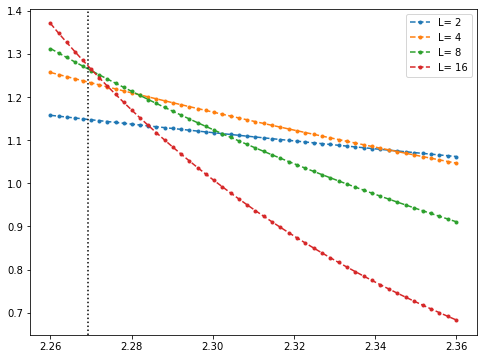

In [31]:
fig = plt.figure(figsize=(8,6))
for i in range(1,int(np.log2(L_max))+1):
    plt.plot(1/beta,xi[(2**i,2**i)],'--.',label='L= %d' %(2**i))
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.show()

# Compare with Square Contraction

In [24]:
T = {}
TM = {}
max_dim = 24
xi_s = {}
L_max = 4  

i=1
while i<=L_max:
    xi_s[(i,i)]=[]
    i*=2

for b in beta:
    i=1
    delta_ut = get_delta(b,h)
    T[(1,1)] = get_T(J,b,delta_ut)
    while i<(L_max):
        T_=merge_y(T[(i,i)],T[(i,i)])
        T[(i*2,i*2)]=merge_x(T_,T_)
        i*=2
        TM[(i,i)] = T[(i,i)].get_block().numpy()
        TM[(i,i)] = np.trace(TM[(i,i)],axis1=0,axis2=3)
        u_,_ = np.linalg.eigh(TM[(i,i)])
        E = -np.log(u_[::-1])
        xi_s[(i,i)].append(1/(E[1]-E[0]))

del T,TM,E

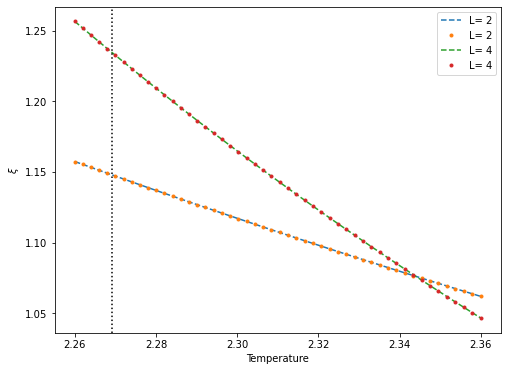

In [35]:
fig = plt.figure(figsize=(8,6))
for i in range(1,3):
    plt.plot(1/beta,xi[(2**i,2**i)],'--',label='L= %d' %(2**i))
    plt.plot(1/beta,xi_s[(2**i,2**i)],'.',label='L= %d' %(2**i))
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.xlabel('Temperature')
plt.ylabel('$\\xi$')
plt.legend()
plt.show()